##### edited by Claire Valva, May 6, 2018

# 1979 to 2016 300hPa at 40.5 deg data processing
will be using file: 1979-2016-300hPa-40.5N-z.nc 
which is currently located in ~/uncategorized data

This file contains a single 2D array called “z”, whose dimension is (240, 55520).  The first dimension is longitude, 1.5 degree interval from 0 to 358.5 (0 is Greenwich Mean).  The second dimension is time, 6 hours apart, from 00 UTC January 1, 1979 to 18 UTC December 31, 2016.  The unit is meters^2/sec^2.  Divide by g = 9.81 m/s^2 to obtain geopotential height, the altitude at which you find 300 hPa.

In [15]:
#import packages, for now everything I think I'll need
import numpy as np
from netCDF4 import Dataset, num2date # This is to read .nc files and time array
from scipy.signal import get_window, csd
from scipy.fftpack import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import pandas as pd
import datetime
from math import pi

In [2]:
filepath = '/home/clairev/uncategorized-data/1979-2016-300hPa-40.5N-z.nc' # Location of the file
fileobj = Dataset(filepath, mode='r')

# Check what's in there
fileobj

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): longitude(240), time(55520)
    variables(dimensions): float32 z(time,longitude)
    groups: 

In [3]:
#load coordinates
height = fileobj.variables['z'][:]/9.81

#create time array
time_list = []
for i in range(0,55520):
    time_list.append(i*6)
tunit = "hours since 1979-01-01T00:00:00Z"
tarray = num2date(time_list,units = tunit,calendar = 'gregorian')
print(tarray)

#create longitude array
lon_list = []
for i in range(240):
    lon_list.append(i*1.5)

[datetime.datetime(1979, 1, 1, 0, 0) datetime.datetime(1979, 1, 1, 6, 0)
 datetime.datetime(1979, 1, 1, 12, 0) ...,
 datetime.datetime(2016, 12, 31, 6, 0)
 datetime.datetime(2016, 12, 31, 12, 0)
 datetime.datetime(2016, 12, 31, 18, 0)]


# plot 1st 3 months of geopotential height

In [23]:
#(for now) use scatterplot to make movie of 1st 3 months of geopotenital height
maxhgt = height[:].max()
minhgt = height[:].min()

for i in range(1): #change range if wish to do again, 1 is used s.t. won't run this by accident
    timestamp = tarray[i]
    
    plt.clf();
    plt.scatter(lon_list[:],height[i], color = "b")
    plt.ylim((minhgt, maxhgt))
    plt.xlim((0,365))
    plt.xlabel('longitude')
    plt.ylabel('geopotential height (m)')
    plt.title('geopotential height on '+str(timestamp))
    plt.tight_layout()
    plt.show

    plt.savefig('405N-processing-pic/geohgt'+str(i).zfill(3)+'.png')

# Hovmoeller diagram

In [28]:
# Setting the contour levels for the colored plot
color_intervals = np.linspace(minhgt * 0.99,
                              maxhgt*1.01, 60,
                              endpoint=True)

# Set the contour levels for the contour lines
contour_intervals = np.linspace(minhgt * 0.99,
                              maxhgt*1.01,
                                20,
                                endpoint=True)

In [39]:
#create list for plotting first few dates
firstdates = tarray[range(360)]
firsthgts = height[range(360)]
    
#create plot    
plt.clf();
plt.figure(figsize=(30, 30)); #a giant image but its detailed
plt.contourf(lon_list, firstdates, firsthgts, color_intervals, cmap='rainbow', alpha=0.5) 
plt.title('Hovmoeller Diagram')
plt.colorbar(shrink=0.5)
plt.contour(lon_list, firstdates, firsthgts, contour_intervals, colors='k', alpha=0.5)
plt.xlabel('longitude')
plt.ylabel('date')
plt.savefig('405N-processing-pic/hovtest.png')

# apply zonal fft to a single snapshot
will determine the amplitudes of wavenumber 1-10 as well as the zonal mean, and make sure that the original data can be recovered by IFFT.

In [4]:
#do fourier transform on the snapshot
snapshot = height[13]
N = 240
T = 1./N
ck = 1/N * fft(snapshot)
xf = fftfreq(N, d=(T)) # sample frequency is cycle/day
print('size of Fourier coeffient array =', ck.size)
print('size of xf =', xf.size)

size of Fourier coeffient array = 240
size of xf = 240


/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


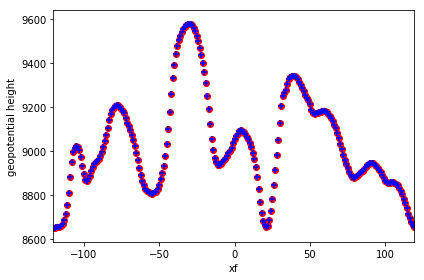

In [5]:
#ensure that data is recovered by ifft
data_recovered = ifft(N * ck)

plt.clf();
plt.scatter(xf,data_recovered, c = 'r')
plt.scatter(xf,snapshot, c = 'b', marker='+')
plt.xlim((xf.min(),xf.max()))
plt.xlabel('xf')
plt.ylabel('geopotential height')
plt.tight_layout()
plt.legend()
plt.show()


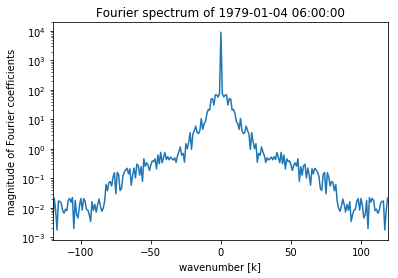

In [6]:
#plot them, fftshift sorts the frequency/wavenumber
plt.clf();
plt.semilogy(fftshift(xf), np.abs(fftshift(ck))) # Take the absolute value. 
plt.title('Fourier spectrum of '+str(tarray[13]))
plt.xlabel('wavenumber [k]');
plt.ylabel('magnitude of Fourier coefficients');
plt.xlim((xf.min(),xf.max()))
plt.show()

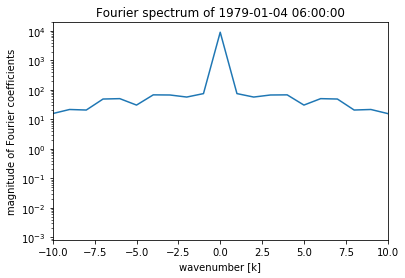

In [7]:
#same plot, but limits wavenumbers to \abs{10}
plt.clf();
plt.semilogy(fftshift(xf), np.abs(fftshift(ck))) # Take the absolute value. 
plt.title('Fourier spectrum of '+str(tarray[13]))
plt.xlabel('wavenumber [k]');
plt.ylabel('magnitude of Fourier coefficients');
plt.xlim((-10,10))
plt.show()

# will apply time-domain fft for 3 months of data
will apply time fft on 126 degrees (lon) and first 3 months worth of data. Will see what the spectra will look like, then repeat with slightly different Hanning window settings, and will then compare on one graph.

In [8]:
#get geopotential height for 126deg (=126/1.5)
lon84 = fileobj.variables['z'][range(360),84]
N = lon84.size
c_lon = 1/N * fft(lon84)
xf_lon = fftfreq(N, d=(0.25)) # sample frequency is cycle/day
print('size of Fourier coeffient array =', c_lon.size)
print('size of xf =', xf_lon.size)

size of Fourier coeffient array = 360
size of xf = 360


/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


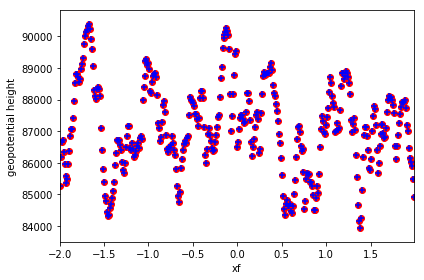

In [9]:
#ensure that data is recovered by ifft/see what it looks like
lon_recovered = ifft(N * c_lon)

plt.clf();
plt.scatter(xf_lon,lon_recovered, c = 'r')
plt.scatter(xf_lon,lon84, c = 'b', marker='+')
plt.xlim((xf_lon.min(),xf_lon.max()))
plt.xlabel('xf')
plt.ylabel('geopotential height')
plt.tight_layout()
plt.legend()
plt.show()

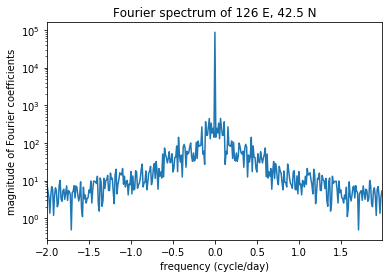

In [10]:
#plot original fft of data
plt.clf();
plt.semilogy(fftshift(xf_lon), np.abs(fftshift(c_lon))) # Take the absolute value. 
plt.title('Fourier spectrum of 126 E, 42.5 N')
plt.xlabel('frequency (cycle/day)');
plt.ylabel('magnitude of Fourier coefficients');
plt.xlim((xf_lon.min(),xf_lon.max()))
plt.show()

In [11]:
#get the hanning window
w1 = get_window('hann', N)

#apply hanning window
lon_w1 = 1/N*fft(lon84*w1)

#compare windowed data to original data
plt.clf();

#using frequency as x-axis
plt.subplots(figsize=(12,4))

ax1 = plt.subplot(121) #(nrows,ncolumns,index)
ax1.semilogy(fftshift(xf_lon),np.abs(fftshift(c_lon))**2, label='original data') #takes the absolute value, fits better with subplots
ax1.set_title('Fourier coefficients (Original data)')
ax1.set_xlabel('frequency $\omega$ [cycle/day]');
ax1.set_ylabel('magnitude of Fourier coefficients');
ax1.set_xlim((0,xf_lon.max()))

ax2 = plt.subplot(122) #(nrows,ncolumns,index)
ax2.semilogy(fftshift(xf_lon), np.abs(fftshift(lon_w1))**2, label='windowed data') #takes the absolute value, fits better with subplots
ax2.set_title('Fourier coefficients (Windowed)')
ax2.set_xlabel('frequency $\omega$ [cycle/day]');
ax2.set_ylabel('magnitude of Fourier coefficients');
ax2.set_xlim((0,xf_lon.max()))

plt.savefig('405N-processing-pic/w1f_test.png')
plt.show

#using period as x-axis
plt.subplots(figsize=(12,4))

ax3 = plt.subplot(121) #(nrows,ncolumns,index)
ax3.plot(1./xf_lon[1:],np.abs(c_lon[1:])**2,'.-', label='original data') #takes the absolute value, fits better with subplots
ax3.set_yscale('log')
ax3.set_title('Fourier coefficients (Original data)')
ax3.set_xlabel('period[day]');
ax3.set_ylabel('magnitude of Fourier coefficients');
ax3.set_xlim((0,90))
             
ax4 = plt.subplot(122) #(nrows,ncolumns,index)
ax4.plot(1./xf_lon[1:],np.abs(lon_w1[1:])**2,'.-', label='windowed data') #takes the absolute value, fits better with subplots
ax4.set_yscale('log')
ax4.set_title('Fourier coefficients (windowed)')
ax4.set_xlabel('period[day]');
ax4.set_ylabel('magnitude of Fourier coefficients');
ax4.set_xlim((0,90))

plt.show

plt.savefig('405N-processing-pic/w1w_test.png')

### Compare Windows of Different Sizes

will use function csd, rather than fft, the scaling is slightly different, but the shape will be the same

###### TO DO: check difference between csd and fft functions in documentation

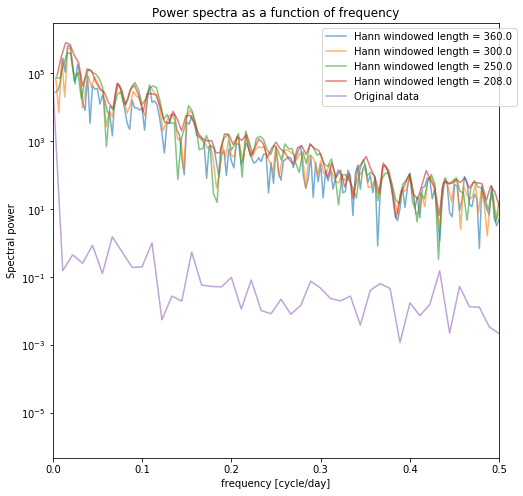

In [27]:
plt.clf();
plt.figure(figsize=(8,8))
for window_length in [N//1.2**i for i in range(4)]:
    freq, power_spec = csd(lon84,lon84, fs=1, 
                           window='hann', 
                           nperseg=window_length, scaling='spectrum')

    plt.semilogy(freq[1:], power_spec[1:], label='Hann windowed length = '+str(window_length), alpha = 0.6)
plt.semilogy(fftshift(xf_lon), np.abs(fftshift(c_lon)/N)**2, label='Original data', alpha = 0.6)
plt.legend(bbox_to_anchor=(1.05,1.0))
plt.title('Power spectra as a function of frequency')
plt.xlabel('frequency [cycle/day]');
plt.ylabel('Spectral power')
plt.xlim((0,0.5))
plt.show()